In this notebook, we will use the German credit risk data from the UCI Machine Learning repository and use it to build a classifier that can efficiently identify bad loans.

Before we start, there are couple of things we should be mindful of:

1. This data is quite old (from 1994), hence the amounts represented are in Deutsch Marks (not Euros).
2. Given the fact that this data was collected a couple of years after German reunification, there is a possibility that the banks would've been operating under different conditions than they are right now. For example, in the early 1990s, Germany had a much higher [interest rate](https://www.ecb.europa.eu/pub/pdf/other/mb200309_focus03.en.pdf) compared to right now. One of the reasons for this was to keep inflation under control. On the other hand, post-unification, a lot of people in the former East Germany realized the marked difference in living standards across the two halves. Hence, we can say that given the access to easy credit in a liberal democracy, German banks were receiving a lot of loan applications in the 1990s, specially from East Germans who wanted to catch up in terms of lifestyle. We can hypothesize that this would've made banks more cautionary when giving out loans. 
3. This data is quite limited. With only 1000 observations and very limited set of variables, predicting is hard. In today's day and age, credit scores (SCHUFA) in Germany are a good way od juding an applicant's credit-worthiness. However, in this dataset, we don't have access to this.

## 1. Importing Data & Missing Values

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("/kaggle/input/german-credit-data-with-risk/german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


We can see that we only have missing values in two columns (Saving accounts & Checking account). 

I think we can assume that NaNs in both of these columns imply that these people don't have bank accounts. Because if they did, I think that would've been logged into the data. Hence, we can fill in this missing values with 'none'. 

In [3]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [4]:
for col in ['Saving accounts', 'Checking account']:
    df[col].fillna('none', inplace=True)


Let's encode the actual values for jobs as described in the data description. Later on, this will make one hot encoding much easier. 

In [5]:
j = {0: 'unskilled and non-res', 1: 'unskilled and res', 2: 'skilled', 3: 'highly skilled'}
df['Job'] = df['Job'].map(j)

df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,skilled,own,none,little,1169,6,radio/TV,good
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,bad
2,49,male,unskilled and res,own,little,none,2096,12,education,good
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,good
4,53,male,skilled,free,little,little,4870,24,car,bad


## 2. EDA & Data Visualization


### 2.1. Distribution of Risk across Job Type and Gender

Observations:
1. Skilled workers are more likely to get 'good' risk rating. This makes sense, as skilled workers tend to earn more and have more job security.
2. Men, throughout all job types, tend to get a 'good' rating much more often than women. Skilled female workers are more commonly classified as 'bad' than 'good'. This hints towards institutional sexism.

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


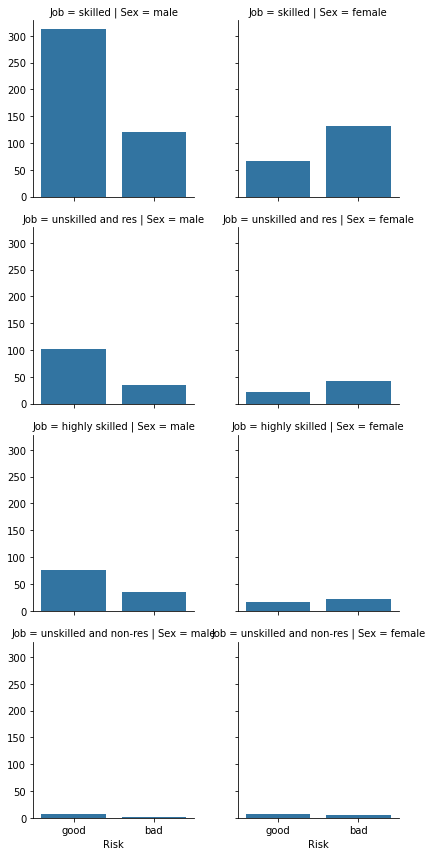

In [6]:
g = sns.FacetGrid(df, col="Sex",  row="Job")
g = g.map(sns.countplot, "Risk")

### 2.2. Distribution of Risk across Housing Status

Observations:
1. People who own their own home are more likely to get a 'good' risk rating on their creit compared to people who rent. This is obvious as credit worthiness goes hand in hand with asset ownership.

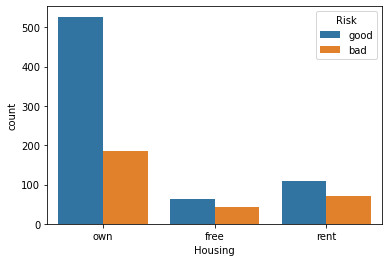

In [7]:
sns.countplot(x="Housing", hue="Risk", data=df)
plt.show()


### 2.3. Distribution of Risk across Bank Account Status

Observations:
1. When it comes to checking accounts, the richer you are, the more likely you are to be classified as 'good'. However, the disparity between 'good' and 'bad' risk ratings when it comes to 'none' is quite astounding. Remember, these are the people who had 'NaN' in the Checking Account column in the original dataset.
2. When it comes to saving accounts, the trend holds as well. The richer you are, the more likley you are to be classified as good. However, unlike checking accounts, where those with 'little' money have equal distribution of good and bad ratings, in savings accounts, there are visibly more good ratings than bad ones. This makes sense since the very existence of a savings account implies some degree of financial security. 

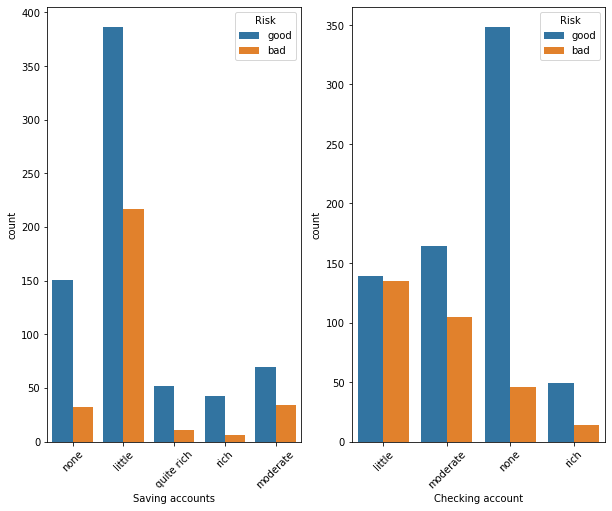

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
sns.countplot(x="Saving accounts", hue="Risk", data=df, ax=ax1)
sns.countplot(x="Checking account", hue="Risk", data=df, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


fig.show()

### 2.4. Boxplots of Distribution of Credit Amounts Across Several Variables

Observations:
1. We notice quite a number of interesting things when we look at the 'Credit Amount Distribution by Purpose'. Firstly, we can see that certain 'purposes' are more likely to have 'bad'ratings, specially if the loan amount is high. For example, if we look at vacation/others, we can see that 'bad' rated loans usually consist of a higher amount. Same can be observed for business loans. Generally, if we exclude furniture/equipment and repairs categories, almost all other categories have a larger interquartile range when it comes to the credit amounts of 'bad' loans. 
2. The radio/TV category has a lot of outliers, specially for loans classified as 'good'. This is quite interesting. It is hard to imagine why a person would borrow 15000 DMs from the bank just to buy a radio or a TV, let alone get his loan approved. 
3. When we look at the amount distributions according to bank account statuses, we observe that rich people tend to borrow less compared to poorer people. On one hand, this makes sense as poor people need more money to take care of their needs. On the other hand, it doesn't make sense for a relatively rich person to borrow a very small amount from the bank. 
4. When it comes to job types, skilled workers tend to have a bigger and higher IQR for bad loans than for good loans. This makes sense since larger amounts are more likely to be classified as 'bad'. However, if we look at unskilled borrowers, this disparity doesn't hold true.

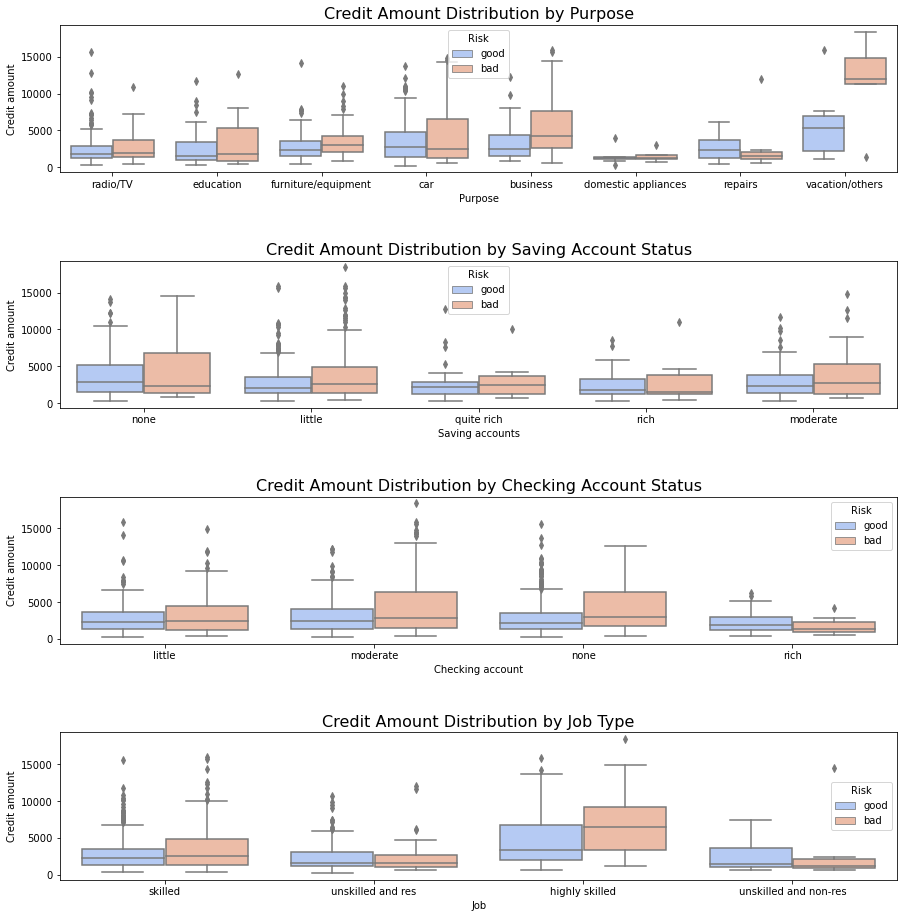

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,25))

sns.boxplot(x="Purpose", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax1)
sns.boxplot(x="Saving accounts", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax2)
sns.boxplot(x="Checking account", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax3)
sns.boxplot(x="Job", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax4)

ax1.set_title("Credit Amount Distribution by Purpose", fontsize=16)
ax2.set_title("Credit Amount Distribution by Saving Account Status", fontsize=16)
ax3.set_title("Credit Amount Distribution by Checking Account Status", fontsize=16)
ax4.set_title("Credit Amount Distribution by Job Type", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.6)
plt.show()


### 2.5. Credit Amount Distribution by Age and Loan Duration

Observations:
1. We can see that generally, throughout all age gaps, bad loans tend to be of a higher amount but when it comes to people over 55, this gap widens. 
2. We can see that when it comes to loan duration, bad and good loans amounts tend to move in tandem. Moreover, larger loans over a longer duration are more likely to be classified as 'good'. 

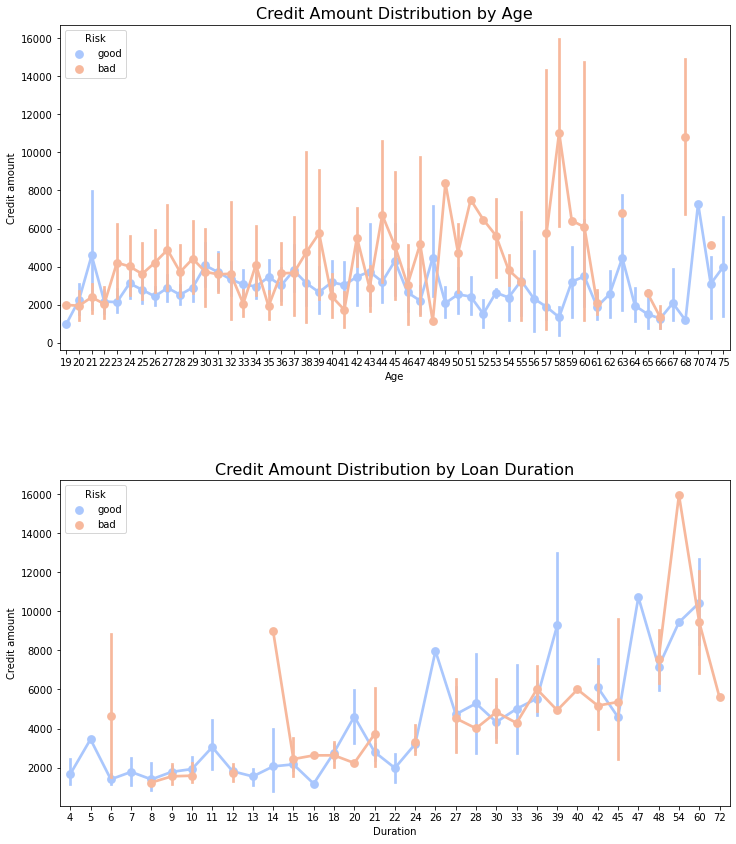

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,14))

sns.pointplot(x="Age", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax1)
sns.pointplot(x="Duration", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax2)

ax1.set_title("Credit Amount Distribution by Age", fontsize=16)
ax2.set_title("Credit Amount Distribution by Loan Duration", fontsize=16)

plt.subplots_adjust(wspace = 0.4, hspace = 0.4,top = 0.9)
plt.show()

## 3. Feature Engineering

### 3.1. Getting Dummies

We need to generate dummies for our categorical variables and then drop the redundant variables. Moreover, as Risk is encoded as 'good' or 'bad'. We need to reencode this as binary. I am encoding 'bad' loans as 1 as from the bank's perspective, we are more interested in identifying bad loans. 

In [11]:
# getting dummies for all the categorical variables
dummies_columns = ['Job', 'Purpose', 'Sex', 'Housing', 'Saving accounts', 'Checking account']
for col in dummies_columns:
    df = df.merge(pd.get_dummies(df[col], drop_first=True, prefix=str(col)), left_index=True, right_index=True) 

# encoding risk as binary
r = {"good":0, "bad": 1}
df['Risk'] = df['Risk'].map(r)

# drop redundant variables
columns_to_drop = ['Job', 'Purpose','Sex','Housing','Saving accounts','Checking account']
df.drop(columns_to_drop, axis=1, inplace=True)

df.head()

    


,Age,Credit amount,Duration,Risk,Job_skilled,Job_unskilled and non-res,Job_unskilled and res,Purpose_car,Purpose_domestic appliances,Purpose_education,...,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_none,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_none,Checking account_rich
0,67,1169,6,0,1,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
1,22,5951,48,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,49,2096,12,0,0,0,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
3,45,7882,42,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,53,4870,24,1,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


### 3.2. Getting Log Amounts

Instead of using the raw credit amount as our dependent variable, we need to get the log of these amounts. This will make our credit amount distribution more normal. 

In [12]:
df['Log_CA'] = np.log(df['Credit amount'])

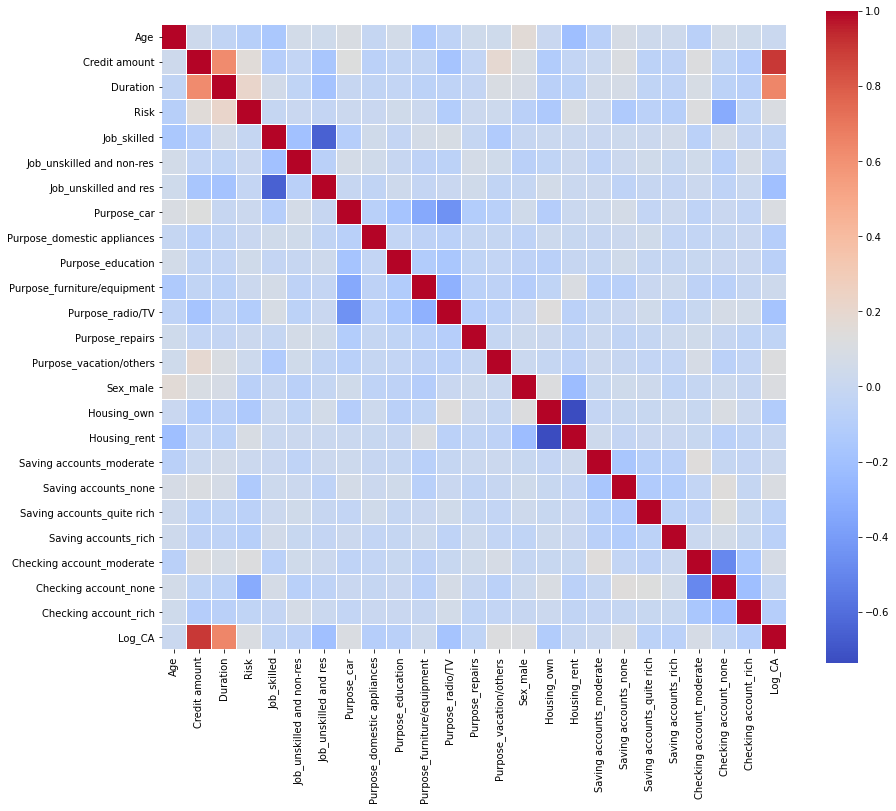

In [13]:
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', cmap='coolwarm')
plt.show()

## 4. Base Models

I test a number of models. For models that have a range of hyperparameters, I run a grid-search first to identify the ideal hyperparameters. 


**Evaluation Metric:**

I will be using 'Recall' as my evaluation metric. To revise, Recall is = True positives / (True positives + False negatives). In our case, the numerator will represent the correct number of bad loans that our algorithm correctly classified as bad while the denomintor will represent the numerator PLUS the bad loans that our algorithm incorrectly classified as 'good'. In other words, the closer the recall value is to 1, the more compeltely were we able to identify all the bad loans. 

In [14]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB



In [15]:
X = df.drop(['Risk', 'Credit amount'], axis=1).values
y = df['Risk'].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)



### 4.1. Logistic Regression

In [16]:
log = LogisticRegression()
log.fit(X_train, y_train)
y_pred_log = log.predict(X_test)
print(accuracy_score(y_pred_log, y_test))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))



0.74
[[126  15]
 [ 37  22]]
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       141
           1       0.59      0.37      0.46        59

    accuracy                           0.74       200
   macro avg       0.68      0.63      0.64       200
weighted avg       0.72      0.74      0.72       200



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 4.2. K-Nearest Neighbors

In [17]:
"""knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid={'n_neighbors':range(1,20)}, scoring='recall')
grid.fit(X_train, y_train)

grid.best_params_

for i in range(0, len(grid.cv_results_['mean_test_score'])):
    print('N_Neighbors {}: {} '.format(i+1, grid.cv_results_['mean_test_score'][i]*100))"""
    
# recall peaks at k = 1

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(accuracy_score(y_pred_knn, y_test))
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

    

0.685
[[117  24]
 [ 39  20]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       141
           1       0.45      0.34      0.39        59

    accuracy                           0.69       200
   macro avg       0.60      0.58      0.59       200
weighted avg       0.66      0.69      0.67       200



### 4.3. Support Vector Classification

In [18]:
"""param_grid_svc = {"gamma": [0.1,0.5,1,5,10,50,100],
                  "C": [0.1,0.5,1,5,10,50,100]}

svc = SVC(kernel='linear')

gs_svc = GridSearchCV(svc, param_grid = param_grid_svc, cv=5, scoring='recall', verbose=4)
gs_svc.fit(X_train, y_train)

gs_svc.best_params_ # gamma = , C = """

svc = SVC(kernel='linear', gamma=10, C=0.8)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print(accuracy_score(y_pred_svc, y_test))
print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))
    


0.76
[[129  12]
 [ 36  23]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       141
           1       0.66      0.39      0.49        59

    accuracy                           0.76       200
   macro avg       0.72      0.65      0.67       200
weighted avg       0.75      0.76      0.74       200



### 4.4. Random Forests

In [19]:
"""param_grid_rf = {"max_depth": range(3,10),
                  "max_features": [3,5,7,9,11,13,15,17,20],
                  "min_samples_leaf": [5,10,15,20,25,30],
                  "n_estimators": [3,5,10,25,50,150]}

rf = RandomForestClassifier()
gs_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=5, scoring="recall", verbose=4)
gs_rf.fit(X_train, y_train)

gs_rf.best_params_
"""
# {'max_depth': 9, 'max_features': 15, 'min_samples_leaf': 5, 'n_estimators': 25}


rf = RandomForestClassifier(max_depth=9, max_features=15, min_samples_leaf=5, n_estimators=25)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(accuracy_score(y_pred_rf, y_test))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


0.75
[[128  13]
 [ 37  22]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       141
           1       0.63      0.37      0.47        59

    accuracy                           0.75       200
   macro avg       0.70      0.64      0.65       200
weighted avg       0.73      0.75      0.73       200



### 4.5. Naive-Bayes

In [20]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print(accuracy_score(y_pred_nb, y_test))
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
    


0.66
[[101  40]
 [ 28  31]]
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       141
           1       0.44      0.53      0.48        59

    accuracy                           0.66       200
   macro avg       0.61      0.62      0.61       200
weighted avg       0.68      0.66      0.67       200



### 4.6. XGBoost

In [21]:
"""param_grid_xgb = {"max_depth": range(3,10),
                  "subsample": [0.5,0.6,0.7,0.8,0.9,1],
                  "eta": [0.01,0.03,0.05,0.07,0.09,0.14,0.19],
                  "colsample_bytree": [0.5,0.6,0.7,0.8,0.9,1],
                  "n_estimators": [3,5,10,25,50,150]}

xgb = XGBClassifier()
gs_xgb = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=5, scoring="recall", verbose=4)
gs_xgb.fit(X_train, y_train)

gs_xgb.best_params_ """

"""{'colsample_bytree': 1,
 'eta': 0.19,
 'max_depth': 8,
 'n_estimators': 150,
 'subsample': 0.8}"""

xgb = XGBClassifier(eta=0.19, max_depth=8, n_estimators=150, subsample=0.8, colsample_bytree=1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(accuracy_score(y_pred_xgb, y_test))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
    


0.74
[[122  19]
 [ 33  26]]
              precision    recall  f1-score   support

           0       0.79      0.87      0.82       141
           1       0.58      0.44      0.50        59

    accuracy                           0.74       200
   macro avg       0.68      0.65      0.66       200
weighted avg       0.73      0.74      0.73       200



### 4.7. Stacked Model

In [22]:
x_training, x_valid, y_training, y_valid = train_test_split(X_train, y_train,
                                                            test_size=0.5,
                                                            random_state=42)
#specify models
model1 = LogisticRegression()
model2 = SVC(kernel='linear', gamma=10, C=0.8)
model3 = GaussianNB()
model4 = XGBClassifier(eta=0.19, max_depth=8, n_estimators=150, subsample=0.8, colsample_bytree=1)
#fit models
model1.fit(x_training, y_training)
model2.fit(x_training, y_training)
model3.fit(x_training, y_training)
model4.fit(x_training, y_training)
#make pred on validation
preds1 = model1.predict(x_valid)
preds2 = model2.predict(x_valid)
preds3 = model3.predict(x_valid)
preds4 = model4.predict(x_valid)
#make pred on test
testpreds1 = model1.predict(X_test)
testpreds2 = model2.predict(X_test)
testpreds3 = model3.predict(X_test)
testpreds4 = model4.predict(X_test)
#form new dataset from valid and test
stackedpredictions = np.column_stack((preds1, preds2, preds3, preds4))
stackedtestpredictions = np.column_stack((testpreds1, testpreds2,
                                              testpreds3, testpreds4))
#make meta model
metamodel = LogisticRegression()
metamodel.fit(stackedpredictions, y_valid)
final_predictions = metamodel.predict(stackedtestpredictions)
    
print(accuracy_score(final_predictions, y_test))
print(confusion_matrix(y_test, final_predictions))
print(classification_report(y_test, final_predictions))
    


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.74
[[135   6]
 [ 46  13]]
              precision    recall  f1-score   support

           0       0.75      0.96      0.84       141
           1       0.68      0.22      0.33        59

    accuracy                           0.74       200
   macro avg       0.72      0.59      0.59       200
weighted avg       0.73      0.74      0.69       200



## 5. Evaluation

According to our evaluation metric, we can see that the Naive-Bayes classifier works the best as it gives us the highest recall. However, when we plot the ROC curves and calculate the AUC for all our models, we can see that SVC and XGB give us the highest AUCs. 

Surprisingly, our stacked model does not perform very well. In fact, it has the lowest recall compared to all the base models. 

                                     fpr                              tpr  \
models                                                                      
LR       [0.0, 0.10638297872340426, 1.0]   [0.0, 0.3728813559322034, 1.0]   
SVC       [0.0, 0.0851063829787234, 1.0]   [0.0, 0.3898305084745763, 1.0]   
NB       [0.0, 0.28368794326241137, 1.0]   [0.0, 0.5254237288135594, 1.0]   
XGB       [0.0, 0.1347517730496454, 1.0]   [0.0, 0.4406779661016949, 1.0]   
Stacked   [0.0, 0.0425531914893617, 1.0]  [0.0, 0.22033898305084745, 1.0]   

              auc  
models             
LR       0.633249  
SVC      0.652362  
NB       0.620868  
XGB      0.652963  
Stacked  0.588893  


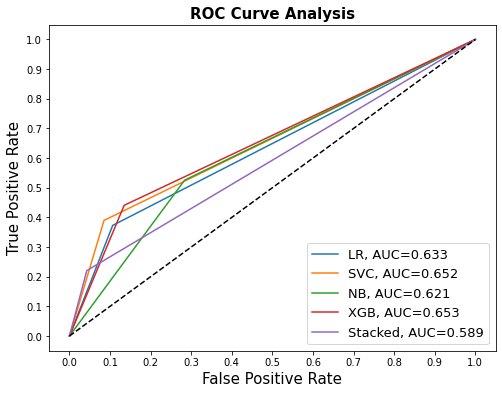

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

results_table = pd.DataFrame(columns = ['models', 'fpr','tpr','auc'])

predictions = {'LR': y_pred_log, 'SVC': y_pred_svc, 'NB': y_pred_nb, 'XGB': y_pred_xgb, 'Stacked': final_predictions}

for key in predictions:
    fpr, tpr, _ = roc_curve(y_test, predictions[key])
    auc = roc_auc_score(y_test, predictions[key])
    
    results_table = results_table.append({'models': key,
                                         'fpr' : fpr,
                                         'tpr' : tpr,
                                         'auc' : auc}, ignore_index=True)
    
results_table.set_index('models', inplace=True)

print(results_table)

fig = plt.figure(figsize = (8,6))

for i in results_table.index:
    plt.plot(results_table.loc[i]['fpr'], 
             results_table.loc[i]['tpr'], 
             label = "{}, AUC={:.3f}".format(i, results_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color = 'black', linestyle = '--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop = {'size':13}, loc = 'lower right')

plt.show()